<h2>CNN and RNN Implementation Using Keras</h2>

This file contains the implementation of a CNN with RNN layers for multiclass sentiment analysis. I will be using Bidirectional LSTM layers within the CNN in order to retain context and connections between words in a sentence. The CNN layers process and extract features from the data.

<h3>Data Preprocessing</h3>

First, the data must be processed. I will be combining all of the statements and their corresponding metadata into one column.

In [68]:
import pandas as pd
import numpy as np
import nltk
import re
from tqdm import tqdm
import os

numeric_labels = {'pants-fire':0, 'false':1, 'barely-true':2, 'half-true':3, 'mostly-true':4, 'true':5}
path = os.getcwd() + '/data'
headers = ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'affiliation', 'barely_true',
           'false', 'half_true', 'mostly_true', 'pants-fire', 'context']
train = pd.read_csv(path + '/train.tsv', sep='\t', header=None, names=headers)
valid = pd.read_csv(path + '/valid.tsv', sep='\t', header=None, names=headers)
test = pd.read_csv(path + '/test.tsv', sep='\t', header=None, names=headers)

train['alltext'] = train['statement'] + ' ' + train['subject'] + ' ' + train['speaker'] + ' ' + train['job_title'] + ' ' + train['state_info'] + ' ' + train['affiliation']
test['alltext'] = test['statement'] + ' ' + test['subject'] + ' ' + test['speaker'] + ' ' + test['job_title'] + ' ' + test['state_info'] + ' ' + test['affiliation']
valid['alltext'] = valid['statement'] + ' ' + valid['subject'] + ' ' + valid['speaker'] + ' ' + valid['job_title'] + ' ' + valid['state_info'] + ' ' + valid['affiliation']

# lowercase, remove punctuation, remove numbers
def clean_text(text):
    if not isinstance(text, str):
        return text
    clean_text = text.lower()
    clean_text = re.sub(r'[^\w\s]', '', clean_text)
    return clean_text

# convert text labels to numbers
def clean_labels(label):
    return numeric_labels[label]

Training data processing:

In [69]:
# data processing: clean text, convert labels to numbers, and remove rows with NaNs
train['alltext'] = train['alltext'].apply(clean_text)
train['label'] = train['label'].apply(clean_labels)
train_data = train[['label', 'alltext']]
train_data = train_data.dropna()

# put cleaned data into csv file
train_data.to_csv('train_data.csv', index=False, header=['label','alltext'])

# print out data head
train_data.head()

,label,alltext
0,1,says the annies list political group supports ...
1,3,when did the decline of coal start it started ...
2,4,hillary clinton agrees with john mccain by vot...
5,5,the chicago bears have had more starting quart...
7,3,im the only person on this stage who has worke...


Validation data processing:

In [70]:
# data processing: clean text, convert labels to numbers, and remove rows with NaNs
valid['alltext'] = valid['alltext'].apply(clean_text)
valid['label'] = valid['label'].apply(clean_labels)
valid_data = valid[['label', 'alltext']]
valid_data = valid_data.dropna()

# put cleaned data into csv file
valid_data.to_csv('valid_data.csv', index=False, header=['label','alltext'])

# print out data head
valid_data.head()

,label,alltext
0,2,we have less americans working now than in the...
2,1,says having organizations parading as being so...
3,3,says nearly half of oregons children are poor ...
4,3,on attacks by republicans that various program...
5,1,says when armed civilians stop mass shootings ...


Test data processing:

In [71]:
# data processing: clean text, convert labels to numbers, and remove rows with NaNs
test['alltext'] = test['alltext'].apply(clean_text)
test['label'] = test['label'].apply(clean_labels)
test_data = test[['label', 'alltext']]
test_data = test_data.dropna()

# put cleaned data into csv file
test_data.to_csv('test_data.csv', index=False, header=['label','alltext'])

# print out data head
test_data.head()

,label,alltext
0,5,building a wall on the usmexico border will ta...
1,1,wisconsin is on pace to double the number of l...
2,1,says john mccain has done nothing to help the ...
3,3,suzanne bonamici supports a plan that will cut...
6,5,says that tennessee law requires that schools ...


We need to also find the number of unique words across all files. To do so, I will combine all three files into one big data file and count the number of unique words in the alltext column.

In [5]:
# combine the dataframes into a single dataframe
combined = pd.concat([train_data, test_data, valid_data], ignore_index=True)

# create a set that holds all the unique words in combined data frame
results = set()
combined['alltext'].str.split().apply(results.update)

# len of set is the number of unique words
num_unique_words = len(results)

Now that the data is processed, it must be tokenized and padded.

<h3>Tokenizing and Padding</h3>

Now, the data is tokenized and padded in order to pass it to the CNN/RNN model.

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

# important to make sure TensorFlow version is okay
if not tf.__version__.startswith('2'):
    raise ValueError('This code requires TensorFlow V2.x')

# max length of sentences
max_len = max(train_data["alltext"].str.len().max(), valid_data["alltext"].str.len().max(), test_data["alltext"].str.len().max())

# create tokenizer and fit it to train data
tokenizer = keras.preprocessing.text.Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(train_data['alltext'])

# create padded matrices for training, validation, and testing sets
train_sequences = tokenizer.texts_to_sequences(train_data['alltext'])
train_padded = keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')

valid_sequences = tokenizer.texts_to_sequences(valid_data['alltext'])
valid_padded = keras.preprocessing.sequence.pad_sequences(valid_sequences, maxlen=max_len, padding='post', truncating='post')

test_sequences = tokenizer.texts_to_sequences(test_data['alltext'])
test_padded = keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

# separate out the labels
train_labels = train_data['label']
valid_labels = valid_data['label']
test_labels = test_data['label']

/Users/anjalisharma/Desktop/CNN/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h3>Model</h3>

Now, we build the CNN/RNN model.

In [ ]:
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Bidirectional, LSTM

CNNRNNmodel = keras.models.Sequential([
    keras.layers.Embedding(num_unique_words,128),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(2),
    Bidirectional(LSTM(32, return_sequences=True, dropout=0.5, recurrent_dropout=0.5, kernel_regularizer=keras.regularizers.l2(0.001))),
    Bidirectional(LSTM(32, dropout=0.5, recurrent_dropout=0.5, kernel_regularizer=keras.regularizers.l2(0.001))),
    keras.layers.Dense(6, activation='softmax')
])

CNNRNNmodel.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(), metrics=["accuracy"])

<h3>Training</h3>

Next, we train the model on 10 epochs to start.

In [58]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = CNNRNNmodel.fit(train_padded, train_labels, epochs=10, validation_data=(valid_padded, valid_labels), callbacks=[early_stop], batch_size=64)

Epoch 1/10


107/107 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.1910 - loss: 0.2662 - val_accuracy: 0.2030 - val_loss: 0.2378
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.1959 - loss: 0.2296 - val_accuracy: 0.2030 - val_loss: 0.2071
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.1924 - loss: 0.2006 - val_accuracy: 0.2030 - val_loss: 0.1820
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.1950 - loss: 0.1766 - val_accuracy: 0.2030 - val_loss: 0.1618
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.1931 - loss: 0.1574 - val_accuracy: 0.2030 - val_loss: 0.1460
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.1953 - loss: 0.1427 - val_accuracy: 0.2030 - val_loss: 0.1340
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.1941 - loss: 0.1313 - val_accuracy: 0.2030 - val_loss: 0.1235
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.1872 - loss: 0.1211 - val_accuracy: 0.203

<h3>Graphs</h3>

We can plot the accuracy and loss for the training and validation sets.

In [59]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy')
    plt.plot(x, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

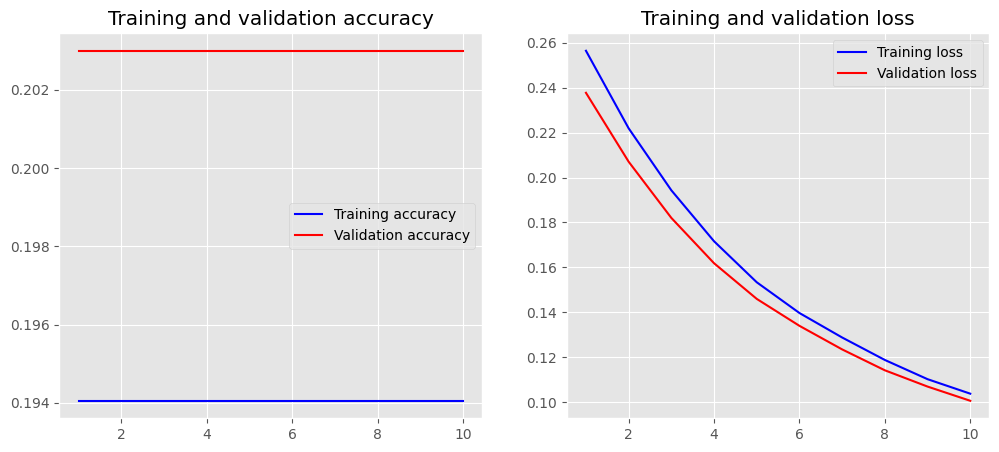

In [60]:
plot_history(history)

<h3>Testing</h3>

Finally, let's see what our test accuracy is so far!

In [65]:
CNNRNNmodel.evaluate(test_padded, test_labels, batch_size=64)

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - accuracy: 0.1910 - loss: 0.1006


[0.10059548169374466, 0.1939953863620758]

We get a 19.36% accuracy.

Maybe adding more layers can help with the accuracy. Also, experimenting with what metadata is being included can posssible help.

<h3>Model Without Any Metadata</h3>

Let's see if the model can perform well without the metadata.

<h4>Preprocess Data (Again)</h4>

In [107]:
train = pd.read_csv(path + '/train.tsv', sep='\t', header=None, names=headers)
valid = pd.read_csv(path + '/valid.tsv', sep='\t', header=None, names=headers)
test = pd.read_csv(path + '/test.tsv', sep='\t', header=None, names=headers)

train['statement'] = train['statement'].apply(clean_text)
valid['statement'] = valid['statement'].apply(clean_text)
test['statement'] = test['statement'].apply(clean_text)
train['label'] = train['label'].apply(clean_labels)
valid['label'] = valid['label'].apply(clean_labels)
test['label'] = test['label'].apply(clean_labels)

train.head()

tr_data = train[['label', 'statement']]
tr_data = tr_data.dropna()
train_statements = tr_data['statement']
train_labels = tr_data['label']

va_data = valid[['label', 'statement']]
va_data = va_data.dropna()
valid_statements = va_data['statement']
valid_labels = va_data['label']

te_data = test[['label', 'statement']]
te_data = te_data.dropna()
test_statements = te_data['statement']
test_labels = te_data['label']

<h4>Tokenizing, Padding, Model Setup, and Training</h4>

In [108]:
# combine the dataframes into a single dataframe
combined = pd.concat([train_statements, test_statements, valid_statements], ignore_index=True)

# create a set that holds all the unique words in combined data frame
results = set()
combined.str.split().apply(results.update)

# len of set is the number of unique words
num_unique_words = len(results)

# max length of statements
max_len = max(train_statements.str.len().max(), valid_statements.str.len().max(), test_statements.str.len().max())

# create tokenizer and fit it to train data
tokenizer = keras.preprocessing.text.Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(train_statements)

# create padded matrices for training, validation, and testing sets
train_sequences = tokenizer.texts_to_sequences(train_statements)
train_padded = keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')

valid_sequences = tokenizer.texts_to_sequences(valid_statements)
valid_padded = keras.preprocessing.sequence.pad_sequences(valid_sequences, maxlen=max_len, padding='post', truncating='post')

test_sequences = tokenizer.texts_to_sequences(test_statements)
test_padded = keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

statements_model = keras.models.Sequential([
    keras.layers.Embedding(num_unique_words,128),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(2),
    Bidirectional(LSTM(32, return_sequences=True, dropout=0.5, recurrent_dropout=0.5, kernel_regularizer=keras.regularizers.l2(0.001))),
    Bidirectional(LSTM(32, dropout=0.5, recurrent_dropout=0.5, kernel_regularizer=keras.regularizers.l2(0.001))),
    keras.layers.Dense(6, activation='softmax')
])

statements_model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(), metrics=["accuracy"])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = statements_model.fit(train_padded, train_labels, epochs=10, validation_data=(valid_padded, valid_labels), callbacks=[early_stop], batch_size=64)

Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.1933 - loss: 2.0388 - val_accuracy: 0.1931 - val_loss: 1.8239
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 246s 2s/step - accuracy: 0.2182 - loss: 1.7942 - val_accuracy: 0.2352 - val_loss: 1.7450
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 245s 2s/step - accuracy: 0.2850 - loss: 1.6521 - val_accuracy: 0.2251 - val_loss: 1.7713
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 246s 2s/step - accuracy: 0.3633 - loss: 1.5016 - val_accuracy: 0.2173 - val_loss: 1.9015
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.4769 - loss: 1.2650 - val_accuracy: 0.2157 - val_loss: 2.0773


<h4>Graphs</h4>

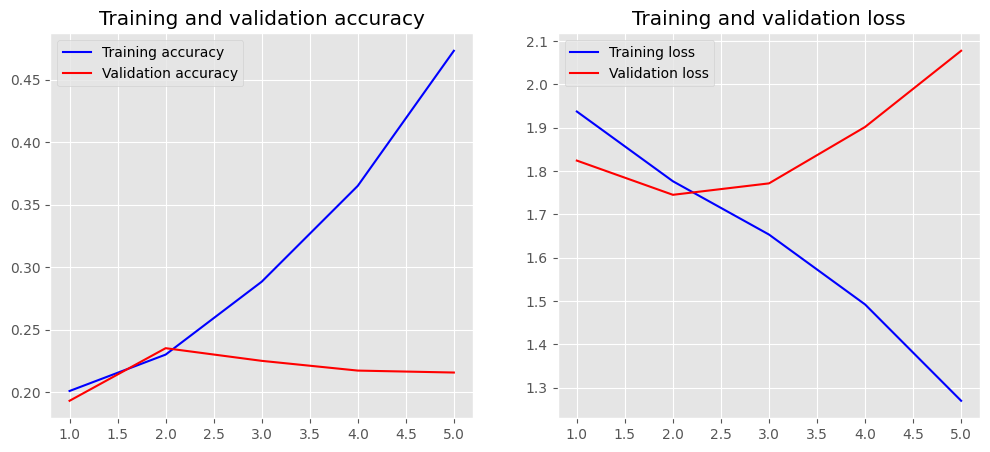

In [109]:
plot_history(history)

<h4>Testing</h4>

Let's see our test accuracy!

In [110]:
statements_model.evaluate(test_padded, test_labels, batch_size=64)

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 326ms/step - accuracy: 0.2311 - loss: 2.1616


[2.082695722579956, 0.2549329102039337]

We get a 25.49% accuracy.

<h3>References</h3>

These are the sources I used when coding. I will look into more stuff as I continue to experiment with the CNN-RNN model.

Luay, M. (2023, September 22). *Sentiment analysis using recurrent neural network(rnn),long short term memory(lstm) and...* Medium. https://medium.com/@muhammadluay45/sentiment-analysis-using-recurrent-neural-network-rnn-long-short-term-memory-lstm-and-38d6e670173f 

Nasir, J. A., Khan, O. S., & Varlamis, I. (2021, January 5). *Fake news detection: A hybrid CNN-RNN based Deep Learning Approach*. International Journal of Information Management Data Insights. https://www.sciencedirect.com/science/article/pii/S2667096820300070#sec0012 